In [2]:
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# English Question Answering with BERT (Clean & Simple)

This notebook fine-tunes an English BERT QA model on a HuggingFace English QA dataset (**SQuAD v2** by default).

## 1) Attention

**Goal:** Use a **query** to pick the most relevant information from **values**.

- **Q (Query):** what I’m searching for  
- **K (Keys):** what I match against  
- **V (Values):** information to combine

**Scaled Dot-Product Attention**
$
\text{Attention}(Q,K,V)=\text{softmax}\left(\frac{QK^\top}{\sqrt{d_k}}\right)V
$

**Intuition:**
1. Similarity: $ QK^ \top$
2. Normalize: softmax → weights  
3. Weighted sum of \(V\)


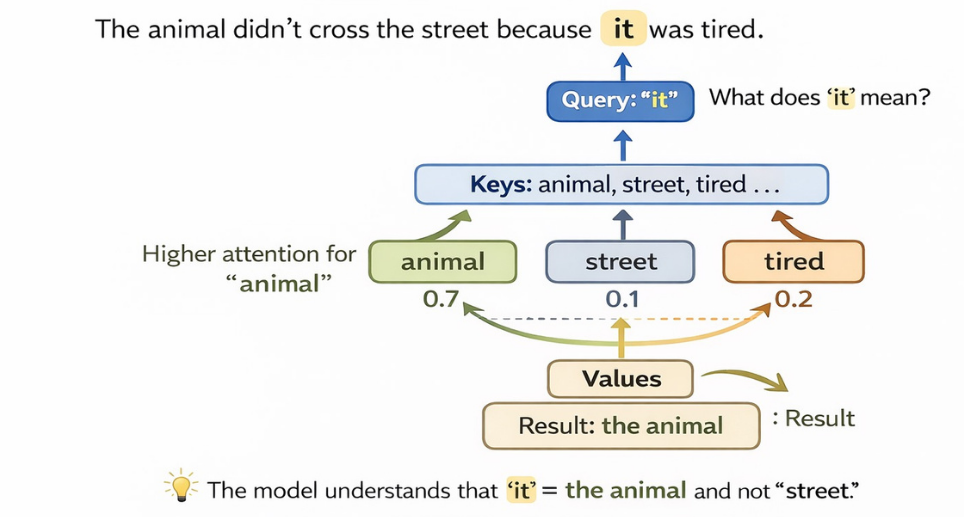

In [3]:
import torch
import torch.nn.functional as F

# Dimensions
# batch = 1
# query_len = 1
# key_len = 4
# d = 8 (embedding size)

Q = torch.randn(1, 1, 8)   # Query
K = torch.randn(1, 4, 8)   # Keys
V = torch.randn(1, 4, 8)   # Values

# 1) Compute similarity scores
scores = torch.matmul(Q, K.transpose(-2, -1))  # (1, 1, 4)

# 2) Normalize scores -> attention weights
weights = F.softmax(scores, dim=-1)             # (1, 1, 4)

# 3) Weighted sum of values
output = torch.matmul(weights, V)               # (1, 1, 8)

print("Scores:", scores)
print("Attention weights:", weights)
print("Output:", output)

Scores: tensor([[[-0.0873, -0.0402,  1.0380,  4.9400]]])
Attention weights: tensor([[[0.0063, 0.0066, 0.0195, 0.9675]]])
Output: tensor([[[ 0.1330,  0.2670, -0.2831, -0.0433,  0.4701,  1.0978, -2.4144,
          -0.4368]]])


## Multi-Head Self-Attention (PyTorch)

This block demonstrates **multi-head self-attention** using PyTorch’s built-in
`nn.MultiheadAttention`.  
Self-attention means the **same tensor is used as Query, Key, and Value**.


In [4]:
import torch
import torch.nn as nn

# ================================
# Multi-Head Self-Attention (FULL)
# ================================

mha = nn.MultiheadAttention(
    embed_dim=128,      # Size of token embeddings (d_model)
    num_heads=4,        # Number of attention heads (128 / 4 = 32 per head)
    dropout=0.1,        # Dropout applied to attention weights (regularization)
    bias=True,          # Add bias to Q, K, V linear projection
    batch_first=True
    # Input shape: (batch, seq_len, embed_dim)
)

# ================================
# Input (Self-Attention)
# ================================

x = torch.randn(2, 10, 128)
# shape: (batch=2, seq_len=10, embed_dim=128)

# Self-attention: Q = K = V = x
out, attn_weights = mha(
    query=x,
    key=x,
    value=x,
    need_weights=True  # return attention matrix
)

# ================================
# Outputs
# ================================

print("Output shape:", out.shape)
# (2, 10, 128) -> contextualized embeddings

print("Attention weights shape:", attn_weights.shape)
# (2, 10, 10) -> who attends to whom


Output shape: torch.Size([2, 10, 128])
Attention weights shape: torch.Size([2, 10, 10])


## Transformer (Encoder)

A **Transformer** is built by stacking multiple **encoder blocks**.
Each block combines **Multi-Head Self-Attention** with a **Feed-Forward Network**,
plus stabilization layers.

---

### Core Components of a Transformer Encoder

1. **Multi-Head Self-Attention**
   - Each token attends to all other tokens.
   - Captures long-range dependencies.
   - Multiple heads learn different relationships.

2. **Feed-Forward Network (FFN)**
   - Applied independently to each token.
   - Expands and compresses features to add non-linearity.

3. **Residual Connections**
   - Add the input back to the output of each sublayer.
   - Help gradients flow in deep networks.

4. **Layer Normalization**
   - Stabilizes training.
   - Applied after each residual connection.

5. **Positional Encoding**
   - Injects word order information (since attention itself is order-agnostic).

---




In [5]:
import torch
import torch.nn as nn

encoder_layer = nn.TransformerEncoderLayer(
    d_model=128,        # Embedding size
    nhead=4,            # Number of attention heads
    dim_feedforward=256,# Hidden size of FFN
    dropout=0.1,
    batch_first=True
)

encoder = nn.TransformerEncoder(
    encoder_layer,
    num_layers=2        # Number of stacked encoder blocks
)

x = torch.randn(2, 10, 128)  # (batch, seq_len, d_model)
out = encoder(x)

print("Output shape:", out.shape)

Output shape: torch.Size([2, 10, 128])


## 1) Install & Imports

In [6]:

!pip install -q transformers datasets accelerate


In [7]:

import os
os.environ["WANDB_DISABLED"] = "true"
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, TrainingArguments, Trainer
from datasets import load_dataset
import transformers
print("Transformers:", transformers.__version__)


Transformers: 4.57.3


## 2) Load English Dataset (SQuAD v2)
You can switch to `squad` (v1) if you want only answerable questions.

In [8]:
dataset = load_dataset("squad_v2")
print(dataset)
print("Train columns:", dataset["train"].column_names)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

squad_v2/train-00000-of-00001.parquet:   0%|          | 0.00/16.4M [00:00<?, ?B/s]

squad_v2/validation-00000-of-00001.parqu(…):   0%|          | 0.00/1.35M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/130319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11873 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 130319
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 11873
    })
})
Train columns: ['id', 'title', 'context', 'question', 'answers']


## 3) Load Model & Tokenizer

In [9]:
model_name = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForQuestionAnswering.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 4) Preprocessing


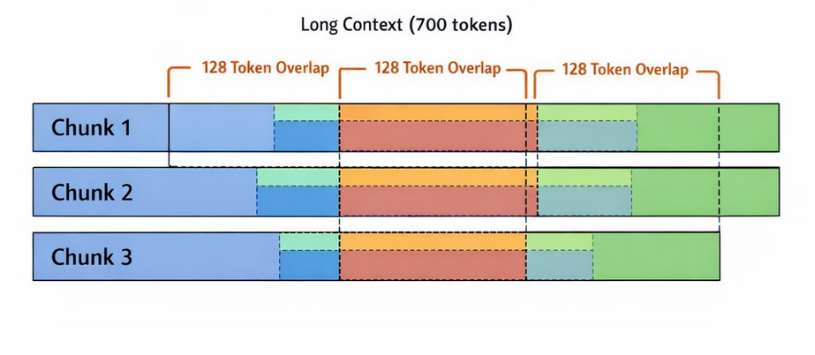

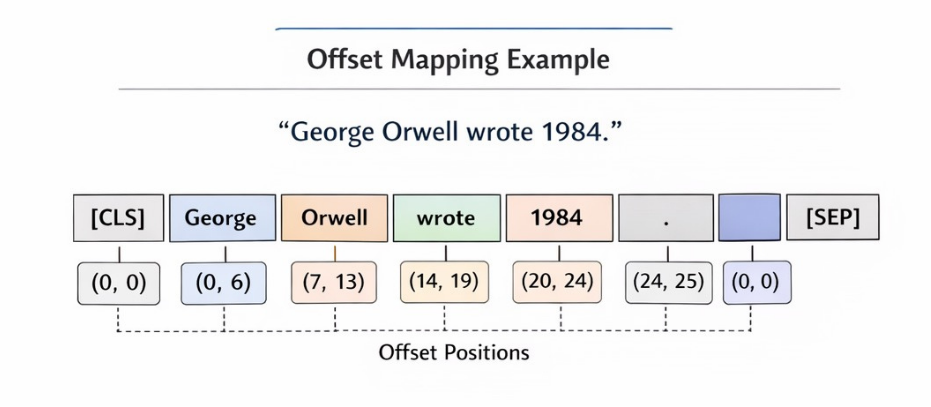

In [10]:
max_length = 384
doc_stride = 128

def prepare_train_features(examples):
    tokenized = tokenizer(
        examples["question"],
        examples["context"],
        truncation="only_second",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_mapping = tokenized["overflow_to_sample_mapping"] #It tells us which original example each tokenized chunk comes from.
    offset_mapping = tokenized["offset_mapping"] #It maps each token back to its character position in the original text.
    start_positions, end_positions = [], [] #start_positions, end_positions = [], []

    for i, offsets in enumerate(offset_mapping): #Loop over every tokenized chunk produced by the tokenizer.
        sample_idx = sample_mapping[i]
        answers = examples["answers"][sample_idx] #It tells us which original example this chunk came from

        # For SQuAD v2: some questions are unanswerable -> set to CLS
        if len(answers["answer_start"]) == 0:
            start_positions.append(0)
            end_positions.append(0)
            continue

        start_char = answers["answer_start"][0]
        end_char = start_char + len(answers["text"][0]) #The character position where the answer starts in the original context string.

        # keep only context tokens (sequence_id == 1)
        seq_ids = tokenized.sequence_ids(i)
        context_idxs = [k for k, s in enumerate(seq_ids) if s == 1] #Identify which tokens belong to the context so we search for the answer only there.

        context_start, context_end = context_idxs[0], context_idxs[-1]

        # if answer not fully inside this window -> CLS
        if offsets[context_start][0] > start_char or offsets[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
            continue

        # find token start
        tok_start = context_start
        while tok_start <= context_end and offsets[tok_start][0] <= start_char:
            tok_start += 1
        start_positions.append(tok_start - 1)

        # find token end
        tok_end = context_end
        while tok_end >= context_start and offsets[tok_end][1] >= end_char:
            tok_end -= 1
        end_positions.append(tok_end + 1)

    tokenized["start_positions"] = start_positions
    tokenized["end_positions"] = end_positions

    # offsets not needed for training
    tokenized.pop("offset_mapping")
    return tokenized


## 5) Make a small subset  


In [11]:

train_raw = dataset["train"].select(range(2000))
eval_raw  = dataset["validation"].select(range(500))

tokenized_train = train_raw.map(prepare_train_features, batched=True, remove_columns=train_raw.column_names)
tokenized_eval  = eval_raw.map(prepare_train_features, batched=True, remove_columns=eval_raw.column_names)

print("Train:", len(tokenized_train), "Eval:", len(tokenized_eval))
print("Features:", tokenized_train.column_names)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Train: 2050 Eval: 507
Features: ['input_ids', 'token_type_ids', 'attention_mask', 'overflow_to_sample_mapping', 'start_positions', 'end_positions']


## 6) Training Arguments


In [12]:
training_args = TrainingArguments(
    output_dir="./bert-qa-squadv2",
    learning_rate=3e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=50,

)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


## 7) Trainer & Train

In [13]:

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    tokenizer=tokenizer,
)

trainer.train()

/tmp/ipython-input-4111999323.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.285500,4.375627
2,1.265500,5.381166
3,0.767800,6.282185
4,0.530100,6.556617
5,0.291200,7.162805


TrainOutput(global_step=1285, training_loss=1.2038957454814985, metrics={'train_runtime': 904.5826, 'train_samples_per_second': 11.331, 'train_steps_per_second': 1.421, 'total_flos': 2008718817408000.0, 'train_loss': 1.2038957454814985, 'epoch': 5.0})

## 8) Quick Inference Example

In [14]:
import torch

# Put model in eval mode
model.eval()

device = next(model.parameters()).device

question = "Who wrote the novel 1984?"
context = "George Orwell wrote the novel 1984, which was published in 1949."

inputs = tokenizer(question, context, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}  # move to GPU/CPU

with torch.no_grad():
    outputs = model(**inputs)


start = torch.argmax(outputs.start_logits, dim=-1).item()
end = torch.argmax(outputs.end_logits, dim=-1).item() + 1

answer = tokenizer.decode(
    inputs["input_ids"][0][start:end],
    skip_special_tokens=True
)

print("Answer:", answer)


Answer: george orwell


In [ ]:
question = "Who announced Saudi Vision 2030?"

context = """
Saudi Vision 2030 is a strategic framework designed to reduce Saudi Arabia’s dependence on oil,
diversify its economy, and develop public service sectors such as health, education, infrastructure,
recreation, and tourism. The vision focuses on empowering citizens, increasing private sector
participation, and improving quality of life across the Kingdom. It also includes ambitious projects
such as NEOM, the Red Sea Project, and Qiddiya. Saudi Vision 2030 was officially announced in 2016
by Crown Prince Mohammed bin Salman as part of a long-term national transformation plan.
"""

answer = "Mohammed bin Salman"


In [16]:
question = "How does PIF contribute to economic diversification?"

context = """
The Public Investment Fund is a key driver of Saudi Arabia’s economic transformation.
It focuses on developing new sectors such as tourism, entertainment, renewable energy,
and advanced technology. Through large-scale investments and partnerships, PIF aims
to reduce reliance on oil revenues and stimulate private sector growth. These efforts
align closely with the objectives of Saudi Vision 2030.
"""
answer = "by developing new sectors and reducing reliance on oil revenues"


In [31]:
import torch


model.eval()
question = "How does PIF contribute to economic diversification?"

context = """
The Public Investment Fund is a key driver of Saudi Arabia’s economic transformation.
It focuses on developing new sectors such as tourism, entertainment, renewable energy,
and advanced technology. Through large-scale investments and partnerships, PIF aims
to reduce reliance on oil revenues and stimulate private sector growth. These efforts
align closely with the objectives of Saudi Vision 2030.
"""
device = next(model.parameters()).device


inputs = tokenizer(question, context, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)


start = torch.argmax(outputs.start_logits, dim=-1).item()
end = torch.argmax(outputs.end_logits, dim=-1).item() + 1

answer = tokenizer.decode(
    inputs["input_ids"][0][start:end],
    skip_special_tokens=True
)

print("Answer:", answer)


Answer: the public investment fund
